In [63]:
%cd /content/drive/My Drive/Colab Notebooks/

/content/drive/My Drive/Colab Notebooks


In [64]:
import pandas as pd
import datetime

In [65]:
target = '202101tmp'

In [66]:
df = pd.read_table(f'data/parsed/{target}.tsv', index_col=0)
df

,date,time,mothermilk,milk,expressedmilk,small,big,sleep
0,2021-01-01,04:45:00,NaN,NaN,NaN,NaN,NaN,0.0
1,2021-01-01,04:55:00,NaN,NaN,NaN,NaN,NaN,1.0
2,2021-01-01,05:02:00,NaN,NaN,NaN,NaN,NaN,0.0
3,2021-01-01,05:15:00,NaN,NaN,NaN,NaN,NaN,1.0
4,2021-01-01,05:18:00,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...
442,2021-01-15,12:30:00,NaN,NaN,NaN,NaN,1.0,NaN
443,2021-01-15,13:15:00,11.0,NaN,NaN,NaN,NaN,NaN
444,2021-01-15,13:15:00,28.0,NaN,NaN,NaN,NaN,NaN
445,2021-01-15,13:15:00,NaN,NaN,NaN,1.0,NaN,NaN


datetime indexをセット

In [67]:
df['datetime'] = pd.to_datetime(df['date'] + 'T' + df['time'])
df = df.set_index('datetime')
df

,date,time,mothermilk,milk,expressedmilk,small,big,sleep
datetime,,,,,,,,
2021-01-01 04:45:00,2021-01-01,04:45:00,NaN,NaN,NaN,NaN,NaN,0.0
2021-01-01 04:55:00,2021-01-01,04:55:00,NaN,NaN,NaN,NaN,NaN,1.0
2021-01-01 05:02:00,2021-01-01,05:02:00,NaN,NaN,NaN,NaN,NaN,0.0
2021-01-01 05:15:00,2021-01-01,05:15:00,NaN,NaN,NaN,NaN,NaN,1.0
2021-01-01 05:18:00,2021-01-01,05:18:00,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...
2021-01-15 12:30:00,2021-01-15,12:30:00,NaN,NaN,NaN,NaN,1.0,NaN
2021-01-15 13:15:00,2021-01-15,13:15:00,11.0,NaN,NaN,NaN,NaN,NaN
2021-01-15 13:15:00,2021-01-15,13:15:00,28.0,NaN,NaN,NaN,NaN,NaN


睡眠時間 (分) をsleep_minutes列にセット

In [68]:
import numpy as np

sleep_series = pd.Series()
sleep_in_time = 0
df['sleep_minutes'] = np.nan

for index, row in df.iterrows():
    if row['sleep'] == 1:
        sleep_in_time = index
    if row['sleep'] == 0 and sleep_in_time is not 0:
        delta = index - sleep_in_time
        df.loc[sleep_in_time, 'sleep_minutes'] = delta.total_seconds() / 60

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


5分間隔のデータに整理

In [69]:
df_5min = df.groupby(pd.Grouper(freq='5min')).sum()
df_5min['sleep_minutes'] = df['sleep_minutes'].groupby(pd.Grouper(freq='5min')).mean()  # 同じ値が同じ時刻のデータすべてに入ってしまっている

1時間ごとに、その時間に入眠した場合にどれくらい(分)眠り続けたかの平均

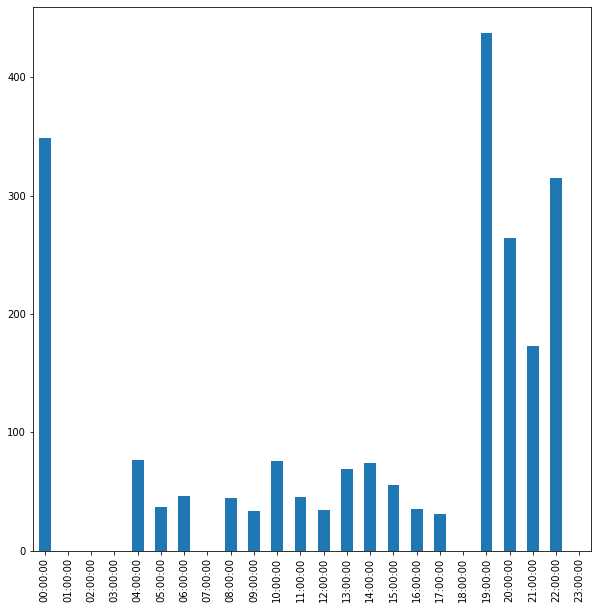

In [70]:
by_hour = df_5min.groupby(lambda x: datetime.time(hour=x.hour)).mean()
by_hour['sleep_minutes'].plot.bar(figsize=(10,10))

分布を確認

In [71]:
df_5min[df_5min['mothermilk'] > 0]['mothermilk'].describe()

count    87.000000
mean     13.839080
std      12.548393
min       4.000000
25%       7.000000
50%       9.000000
75%      11.000000
max      44.000000
Name: mothermilk, dtype: float64

In [72]:
df_5min[df_5min['milk'] > 0]['milk'].describe()

count     14.0
mean     200.0
std        0.0
min      200.0
25%      200.0
50%      200.0
75%      200.0
max      200.0
Name: milk, dtype: float64

In [73]:
df_5min[df_5min['expressedmilk'] > 0]['expressedmilk'].describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: expressedmilk, dtype: float64

In [74]:
df_5min[df_5min['sleep_minutes'] > 0]['sleep_minutes'].describe()

count     97.000000
mean     119.453608
std      163.890653
min        3.000000
25%       30.000000
50%       45.000000
75%      110.000000
max      640.000000
Name: sleep_minutes, dtype: float64

ある時刻より前の最後のイベントを取得する関数

In [75]:
def last_event_by(df, time, column):
    rows = df[:time][df[:time][column] > 0]
    if len(rows) == 0:
        return 0, 0, 0
    row = rows.iloc[-1]
    delta = time - row.name
    return row.name, row[column], delta.total_seconds() / 60

last_event_by(df_5min, pd.to_datetime('2020-10-02 03:00'), 'mothermilk')

(0, 0, 0)

睡眠時間と、その直前の各種イベントの内容をデータセット化

In [76]:
sleep_df = pd.DataFrame(columns=['datetime', 'hour', 'sleep_minutes', 'last_mothermilk', 'last_mothermilk_before', 'last_milk', 'last_milk_before', 'last_small_before', 'last_big_before'])

for index, row in df_5min.iterrows():
    if row['sleep_minutes'] > 0:
        mothermilk_time, mothermilk, mothermilk_before = last_event_by(df_5min, index, 'mothermilk')
        milk_time, milk, milk_before = last_event_by(df_5min, index, 'milk')
        small_time, small, small_before = last_event_by(df_5min, index, 'small')
        big_time, big, big_before = last_event_by(df_5min, index, 'big')
        sleep_df = sleep_df.append({
            'datetime': index,
            'hour': index.hour,
            'sleep_minutes': row['sleep_minutes'],
            'last_mothermilk': mothermilk,
            'last_mothermilk_before': mothermilk_before,
            'last_milk': milk,
            'last_milk_before': milk_before,
            'last_small_before': small_before,
            'last_big_before': big_before
        }, ignore_index=True)

sleep_df

,datetime,hour,sleep_minutes,last_mothermilk,last_mothermilk_before,last_milk,last_milk_before,last_small_before,last_big_before
0,2021-01-01 04:55:00,4,7.0,0,0,0,0,0,0
1,2021-01-01 05:15:00,5,3.0,0,0,0,0,0,0
2,2021-01-01 05:40:00,5,9.0,0,0,0,0,5,0
3,2021-01-01 06:25:00,6,47.0,0,0,0,0,50,0
4,2021-01-01 08:30:00,8,50.0,11,75,0,0,10,0
...,...,...,...,...,...,...,...,...,...
92,2021-01-14 11:30:00,11,120.0,7,90,200,1000,25,930
93,2021-01-14 15:15:00,15,40.0,12,95,200,1225,30,1155
94,2021-01-14 20:05:00,20,640.0,41,0,200,70,0,0
95,2021-01-15 08:35:00,8,40.0,9,95,200,820,100,750


In [77]:
sleep_df.to_csv(f'data/preprocessed/sleep_{target}.tsv', sep='\t')